## Image denoising with Haar-Laplace Pior

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pywt
import seaborn as sns

In [0]:
def wavelet(x, level, dim_x):
    x = x.reshape((dim_x, dim_x))
    wave = pywt.wavedec2(x, 'Haar', level=level, axes = (0,1))
    y = list(wave[0].reshape(np.prod(wave[0].shape)))
    for i in range(1, len(wave)):
        for imgt in wave[i]:
            y.extend(list(imgt.reshape(np.prod(imgt.shape))))

    return np.array(y)

def wavelet_rec(y, level):
    l = int(y.shape[0]/2**(2*level))
    s = int(np.sqrt(l))
    coeffs = [y[:l].reshape((s, s))]
    y = y[l:]
    for i in range(level):
        x1 = []
        for j in range(3):
            s = int(np.sqrt(l))
            x1.append(y[:l].reshape((s, s)))
            y = y[l:]
        coeffs.append(tuple(x1))
        l = l*4
    return pywt.waverec2(coeffs, 'Haar', axes=(0, 1)).flatten()

In [0]:
class MCMC_image:
    def __init__(self, sigma, y, theta_ini = None, approx = False):
        # Parameters and data
        self.sigma = sigma
        self.level = 4
        self.approx = approx

        ## To compute : Lipschitz constant for fy (constant for the wavelet operation here =1) and update lamb = 1/L and gamma
        ## I find that the lipshcitz constant is 1/sigma**2 since psi.T*psi = I
        self.lamb = self.sigma**2
        self.gamma = 0.98*(1/((1/self.sigma**2)+1/self.lamb))
        self.y = y
        self.dim = y.shape[0]
        self.dim_x = int(np.sqrt(self.dim))
        self.n_approx = int((self.dim_x/2**self.level)**2)

        # Length of the chain
        self.step = 1

        #State of the chain and theta
        self.X = [np.random.laplace(size = dim)]
        #self.theta = [np.abs(np.random.randn(1))[0]]
        if theta_ini == None:
            self.theta = [np.random.rand()*3+0.5]
        else:
            self.theta = [theta_ini]
        self.delta = (10/(self.theta[-1]*self.dim))

  # Apply gradient on U(Xk)
    def grad_U(self, c):
        final = -(1/(self.sigma)**2)*wavelet(self.y - wavelet_rec(c, self.level), self.level, self.dim_x)
        return final

  # Apply proximal gradient on state V(Xk)
    def proximal_grad(self, c):
        #Try : Apply gradient only on the details coefficients:
        if self.approx:
            c_details = c
        else:
            c_approx, c_details = c[:self.n_approx] , c[self.n_approx:]
        if self.step > 10:
            theta = self.theta[-1]
        else: 
            theta = self.theta[0]
        final = np.sign(c_details) * np.maximum(np.abs(c_details) - theta*self.lamb, 0)

        if self.approx:
            return final
        else:
            return np.append(c_approx, final)
    def kernel(self,c):
        noise = np.random.randn(self.dim)
        c_next = c - self.gamma*self.grad_U(c) - self.gamma*(c - self.proximal_grad(c))/self.lamb + np.sqrt(2*self.gamma)*noise
        return c_next

    # Update the chain for both X and theta
    def one_step(self):
        next_X = self.kernel(self.X[-1])
        self.X.append(next_X)
        self.step += 1
        self.delta = self.delta*(((self.step - 1) / self.step)**0.8)

        ## Analysis terms:
        #print("Analysis terms")
        # Try : Only details coef
        if self.approx:
            next_theta = self.theta[-1] + self.delta*(self.dim/self.theta[-1] - np.linalg.norm(self.X[-1], ord = 1))
        else:
            next_theta = self.theta[-1] + self.delta*(self.dim/self.theta[-1] - np.linalg.norm(self.X[-1][self.n_approx:], ord = 1))
        next_theta = max(min(next_theta, 100), 0.001)
        self.theta.append(next_theta)

## Simulation

### Simulation 1 : Behaviour of the chain of theta $\theta$

In [1]:
## Parameters distribution
sigma = 0.1
theta = 2
dim = 256*256
dim_x = 256

## Function for sampling
def sample_y(theta, sigma, dim = dim):
    # Wavelet coef
    x = np.random.laplace(scale = 1/theta, size = dim)
    # Observation
    noise = sigma*np.random.randn(dim)
    return wavelet_rec(x, level = 4) + noise

#### Effect of the initialisation

0.0% done
20.0% done
40.0% done
60.0% done
80.0% done


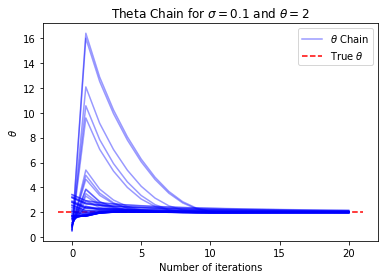

In [0]:
# Number of chains for theta
n_est = 50
nb_iteration = 20

for i in range(n_est):
    y = sample_y(theta, sigma)
    chain = MCMC_image(sigma, y)
    for j in range(nb_iteration):
        chain.one_step()
    if i == n_est - 1:
        plt.plot(chain.theta, '-b', alpha=0.4, label = r'$\theta$ Chain')
    else:
        plt.plot(chain.theta, '-b', alpha=0.4)
    if i%10 == 0:
        print(str(100*i/n_est) + "% done")
plt.hlines(theta, -1, nb_iteration + 1, colors = 'r', linestyles = 'dashed', label = r'True $\theta$')
plt.xlabel("Number of iterations")
plt.ylabel(r'$\theta$')
plt.title("Theta Chain for "+ r'$\sigma = $' + str(sigma) + " and " r'$\theta = $' + str(theta)  )
plt.legend()
plt.savefig("Multiple_Init.png")

#### Effect of $\sigma$

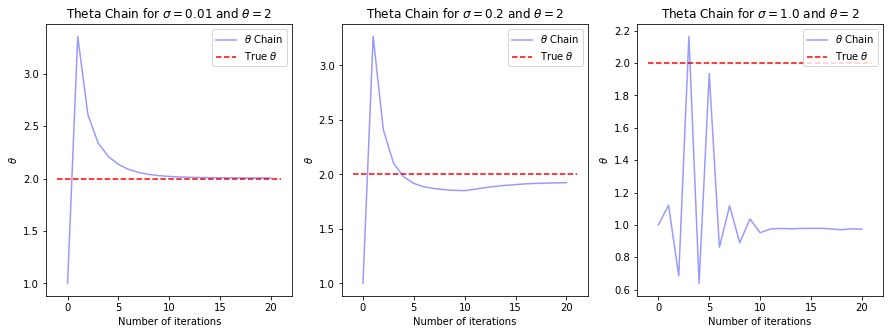

In [28]:
## EXPERIMENT TO ASSESS SIGMA

# Number of estimation of theta
nb_iteration = 20
list_sigma = [0.01,0.2,1.]
fig, axs = plt.subplots(1, 3, figsize=(15,5))

for i, sigma in enumerate(list_sigma):
    y = sample_y(theta, sigma)
    chain = MCMC_image(sigma, y, theta_ini=1.)
    for j in range(nb_iteration):
        chain.one_step()
    axs[i].plot(chain.theta, '-b', alpha=0.4, label =  r'$\theta$ Chain')
    axs[i].hlines(theta, -1, nb_iteration + 1, colors = 'r', linestyles = 'dashed', label = r'True $\theta$')
    axs[i].set_xlabel("Number of iterations")
    axs[i].set_ylabel(r'$\theta$')
    axs[i].set_title("Theta Chain for "+ r'$\sigma = $' + str(sigma) + " and " r'$\theta = $' + str(theta)  )
    axs[i].legend()
plt.savefig("Multiple_Sigma.pdf")

#### Effect of the dimension

256.0
512.0
1024.0


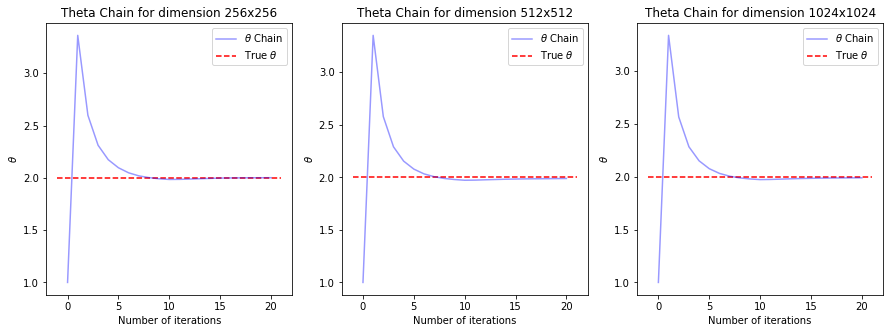

In [0]:
## EXPERIMENT TO ASSESS THE DIMENSION

# Number of estimation of theta
nb_iteration = 20
sigma = 0.1
list_dimension = [256*256, 512*512, 1024*1024]
fig, axs = plt.subplots(1, 3, figsize=(15,5))

for i, dim in enumerate(list_dimension):
    y = sample_y(theta, sigma, dim = dim)
    chain = MCMC_image(sigma, y, theta_ini=1.)
    for j in range(nb_iteration):
        chain.one_step()
    axs[i].plot(chain.theta, '-b', alpha=0.4, label =  r'$\theta$ Chain')
    axs[i].hlines(theta, -1, nb_iteration + 1, colors = 'r', linestyles = 'dashed', label = r'True $\theta$')
    axs[i].set_xlabel("Number of iterations")
    axs[i].set_ylabel(r'$\theta$')
    axs[i].set_title("Theta Chain for dimension " + str(int(np.sqrt(dim))) + "x" + str(int(np.sqrt(dim))) )
    axs[i].legend()
plt.savefig("Multiple_Dm.pdf")

### Simulation 2 : Recover $\theta$

In [0]:
## Parameters distribution
sigma = 0.1
theta = 2
dim = 256*256
dim_x = 256

Simulation for sigma = 0.01
0.0% done
5.0% done
10.0% done
15.0% done
20.0% done
25.0% done
30.0% done
35.0% done
40.0% done
45.0% done
50.0% done
55.0% done
60.0% done
65.0% done
70.0% done
75.0% done
80.0% done
85.0% done
90.0% done
95.0% done
Simulation for sigma = 0.1
0.0% done
5.0% done
10.0% done
15.0% done
20.0% done
25.0% done
30.0% done
35.0% done
40.0% done
45.0% done
50.0% done
55.0% done
60.0% done
65.0% done
70.0% done
75.0% done
80.0% done
85.0% done
90.0% done
95.0% done
Simulation for sigma = 1.0
0.0% done
5.0% done
10.0% done
15.0% done
20.0% done
25.0% done
30.0% done
35.0% done
40.0% done
45.0% done
50.0% done
55.0% done
60.0% done
65.0% done
70.0% done
75.0% done
80.0% done
85.0% done
90.0% done
95.0% done


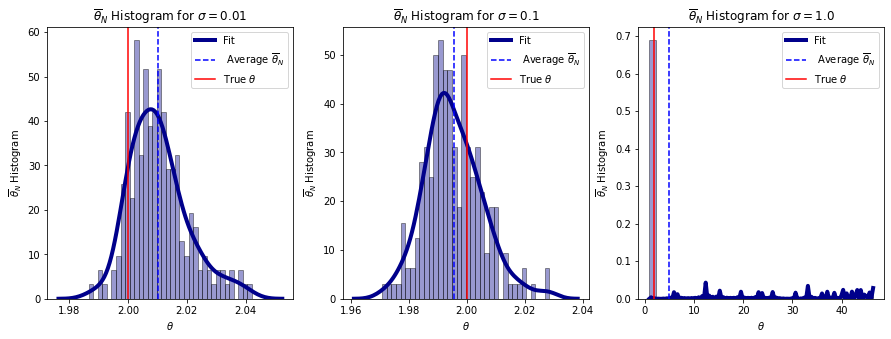

In [23]:
## EXPERIMENT TO RECOVER THETA

# Number of estimation of theta
n_est = 200
nb_iteration = 80
list_sigma = [0.01,0.2,1.]
fig, axs = plt.subplots(1, 3, figsize=(15,5))

for k, sigma in enumerate(list_sigma):
    list_theta = []
    print("Simulation for sigma = " + str(sigma))
    for i in range(n_est):
        y = sample_y(theta, sigma)
        chain = MCMC_image(sigma, y)
        for j in range(nb_iteration):
            chain.one_step()
        #list_theta.append(np.array(chain.theta).mean())
        list_theta.append(chain.theta[-1])
        if i%10 == 0:
            print(str(100*i/n_est) + "% done")
    sns.distplot(np.array(list_theta), hist=True, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4, 'label':"Fit"}, ax=axs[k])
    axs[k].axvline(x=np.array(list_theta).mean(), ymin=0, ymax=1, color = 'b', label = r' Average $\overline{\theta}_{N}$', linestyle = "dashed")
    axs[k].axvline(x=theta, ymin=0, ymax=1, color = 'r', label = r'True $\theta$')
    axs[k].set_xlabel(r'$\theta$')
    axs[k].set_ylabel(r'$\overline{\theta}_{N}$' + " Histogram")
    axs[k].set_title(r'$\overline{\theta}_{N}$' + " Histogram for " + r'$\sigma = $' + str(sigma))
    axs[k].legend()
plt.savefig("Theta_Histogram.pdf")